## **AOL Kelompok 3**
- Alexander Rafael -  2702256542
- Patrick Surya Pranata - 2702267716
- Richard Dean Tanjaya - 2702262652

In [3]:
# Basic library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing library
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model library
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Remove warnings
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [4]:
def plot_dist(df, col):
    fig, axs = plt.subplots(ncols = 2, nrows = 1,figsize = (10, 4))

    # Plot Histogram
    sns.histplot(df[col], ax = axs[0], bins=30)
    axs[0].set_title(f"Histogram {col}")
    axs[0].axvline(df[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axs[0].axvline(df[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axs[0].legend()

    # Plot Boxplot
    sns.boxplot(y=df[col], ax =  axs[1])
    axs[1].set_title(f"Boxplot {col}")

    plt.show()

    # Print Skewness
    print('Skewness :', df[col].skew())
    if -0.1 <= df[col].skew() <= 0.1:
        print("Column |{}| normal distribution".format(col))
    elif df[col].skew() > 0.1:
        print("Column |{}| right skewed".format(col))
    elif df[col].skew() < -0.1:
        print("Column |{}| left skewed".format(col))

    print("========================================================================================")

## Data Analysis

In [5]:
df = pd.read_csv('weather_classification_data.csv')
display(df.head())
print(f'Rows: {df.shape[0]} x Cols: {df.shape[1]}')

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


Rows: 13200 x Cols: 11


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [7]:
df.isnull().sum()

,0
Temperature,0
Humidity,0
Wind Speed,0
Precipitation (%),0
Cloud Cover,0
Atmospheric Pressure,0
UV Index,0
Season,0
Visibility (km),0
Location,0


In [8]:
df[df.duplicated()].any()

,0
Temperature,False
Humidity,False
Wind Speed,False
Precipitation (%),False
Cloud Cover,False
Atmospheric Pressure,False
UV Index,False
Season,False
Visibility (km),False
Location,False


## Data Visualization

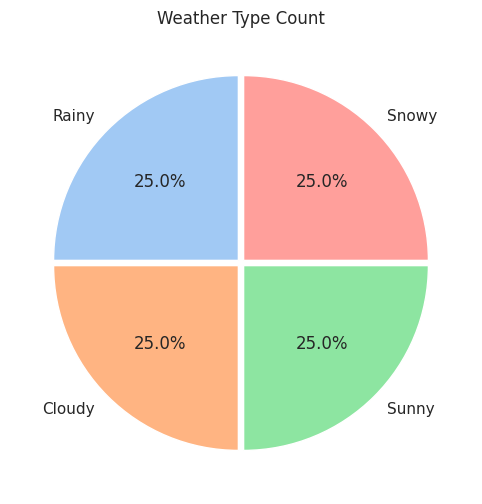

In [61]:
data = df['Weather Type'].value_counts()
label = data.index

colors = sns.color_palette('pastel', len(label))

plt.figure(figsize = (8,6))
plt.pie(data, labels = label, autopct = '%1.1f%%',
        explode = [0.02] * len(label),
        startangle = 90,
        colors = colors)
plt.title('Weather Type Count')
plt.show()

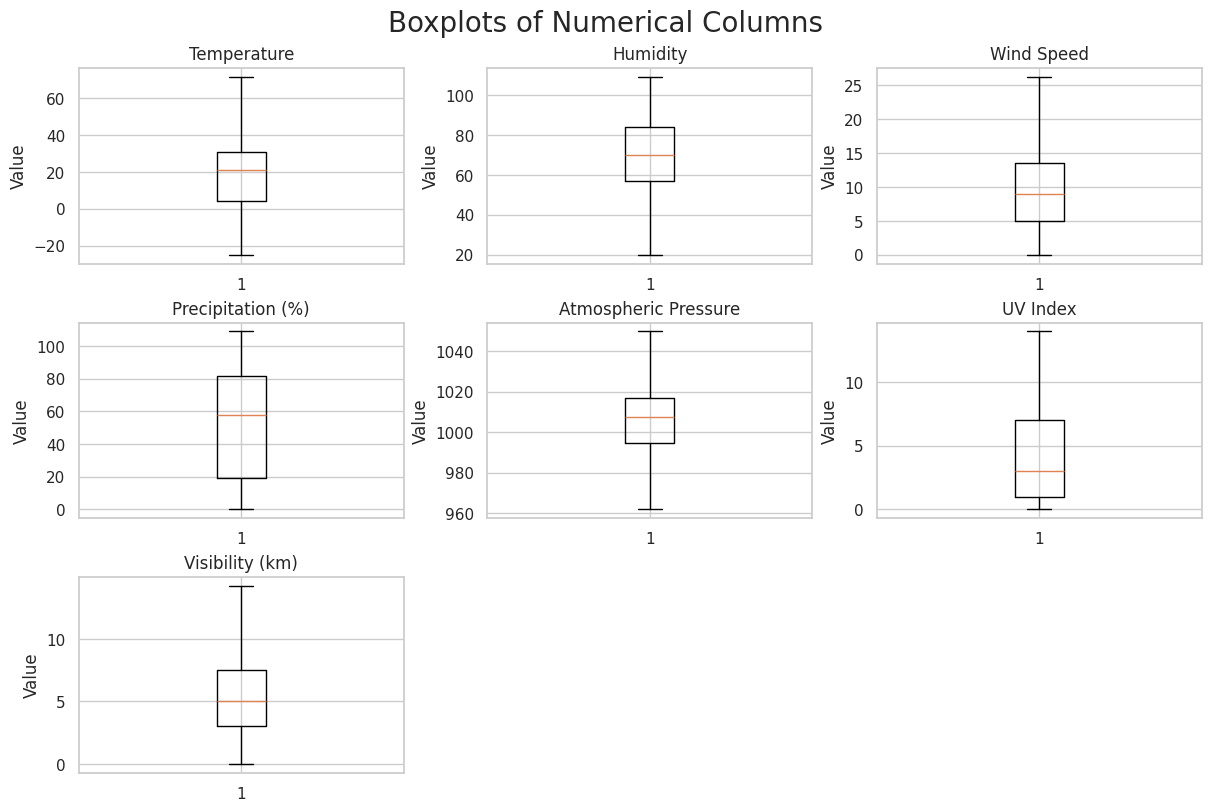

In [64]:
numeric_df = df.select_dtypes(include = 'number')

fig, axes = plt.subplots(3, 3, figsize = (12, 8), constrained_layout=True)

for i, col in enumerate(numeric_df):
    row, col_idx = divmod(i, 3)
    axes[row, col_idx].boxplot(df[col])
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_ylabel("Value")

# Remove empty
fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

plt.suptitle("Boxplots of Numerical Columns", fontsize = 20)
plt.show()

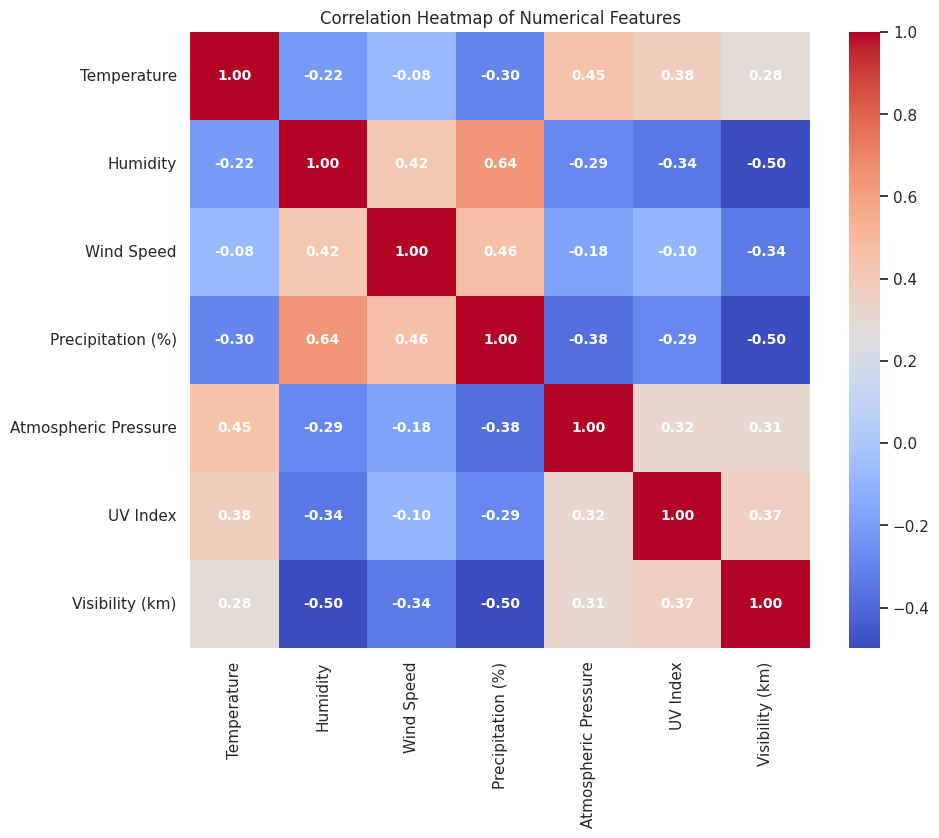

In [65]:
numeric_df = df.select_dtypes(include = 'number')
corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot = True,
            cmap='coolwarm',
            fmt = '.2f',
            annot_kws = {'size': 10, 'weight':'bold', 'color':'white'})
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## Data Cleaning

### **Outlier Handling**

In [10]:
num_int_cols = df.select_dtypes(include = ['float64', 'int64']).columns
num_int_cols = list(num_int_cols)
object_cols = df.select_dtypes(include = 'object').columns
object_cols = list(object_cols)

display(num_int_cols, object_cols)

['Temperature',
 'Humidity',
 'Wind Speed',
 'Precipitation (%)',
 'Atmospheric Pressure',
 'UV Index',
 'Visibility (km)']

['Cloud Cover', 'Season', 'Location', 'Weather Type']

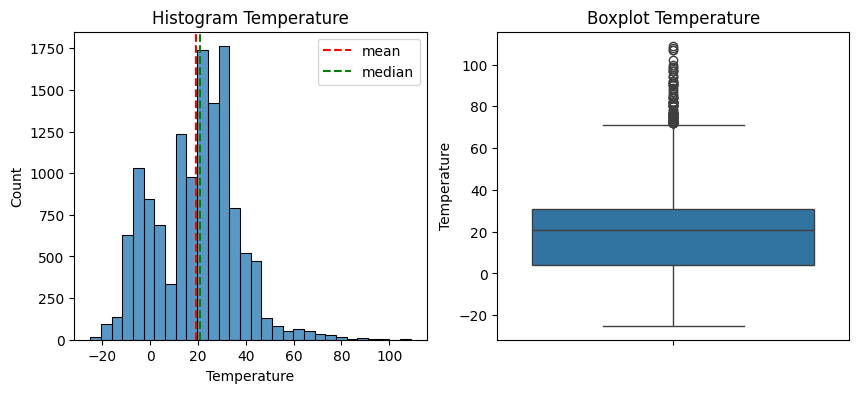

Skewness : 0.2217414467117672
Column |Temperature| right skewed


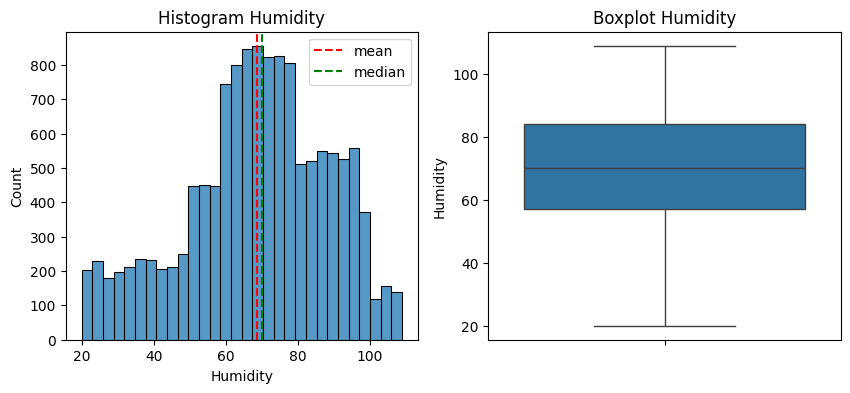

Skewness : -0.40161426558981855
Column |Humidity| left skewed


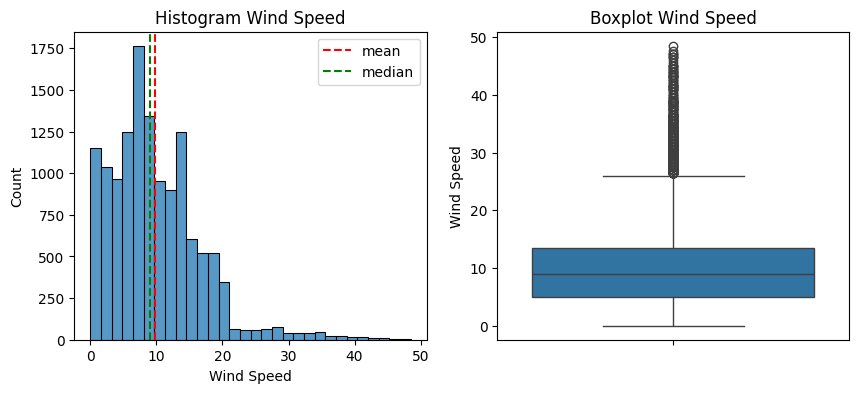

Skewness : 1.3602625756285232
Column |Wind Speed| right skewed


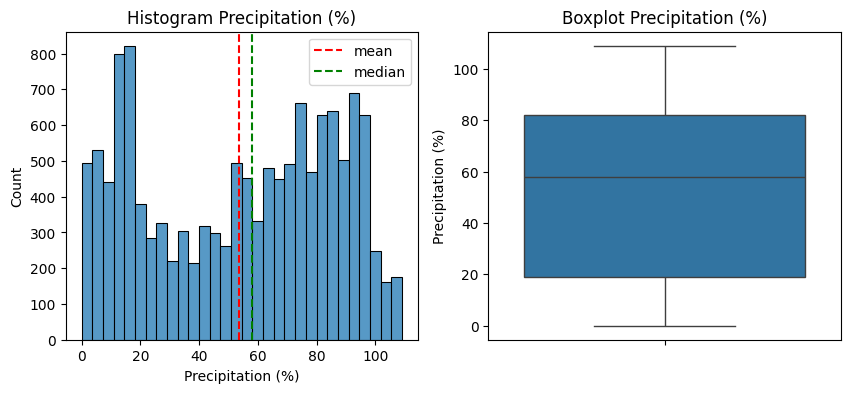

Skewness : -0.15245706717664612
Column |Precipitation (%)| left skewed


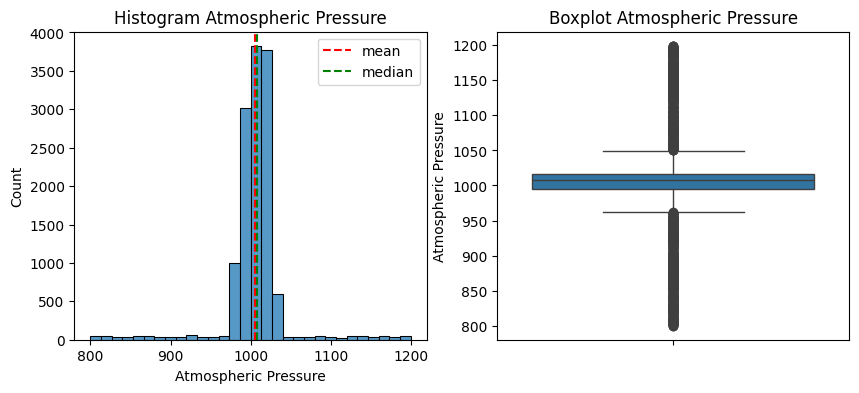

Skewness : -0.2938986063675234
Column |Atmospheric Pressure| left skewed


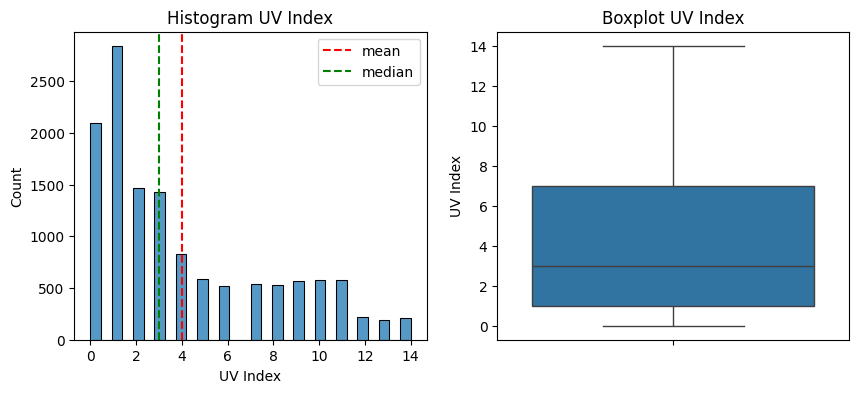

Skewness : 0.9000101823909895
Column |UV Index| right skewed


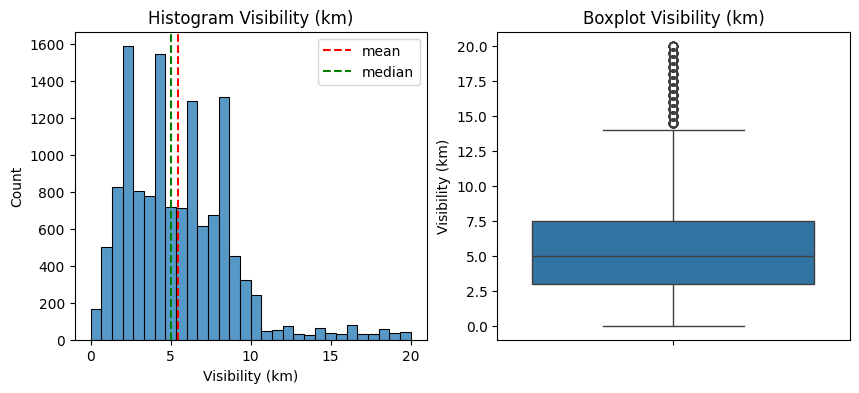

Skewness : 1.2332751645049822
Column |Visibility (km)| right skewed


In [11]:
for col in num_int_cols:
    plot_dist(df, col)

In [12]:
winsorizer = Winsorizer(capping_method = 'iqr',
                         tail = 'both',
                         fold = 1.5,
                         variables = num_int_cols
                         )

In [13]:
df = winsorizer.fit_transform(df)

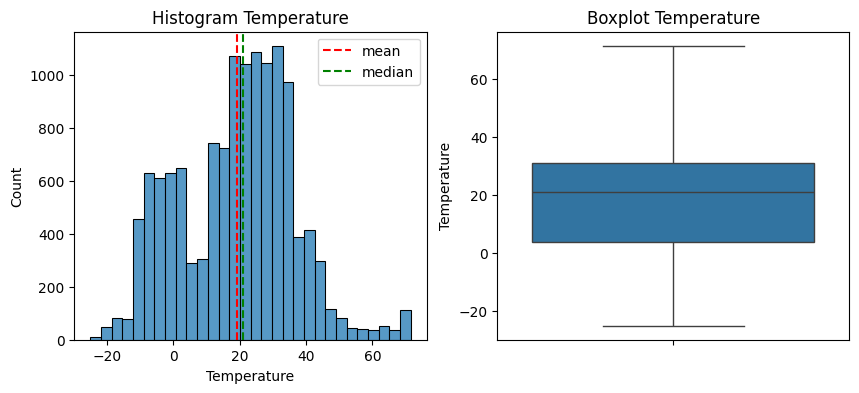

Skewness : 0.06483970986495137
Column |Temperature| normal distribution


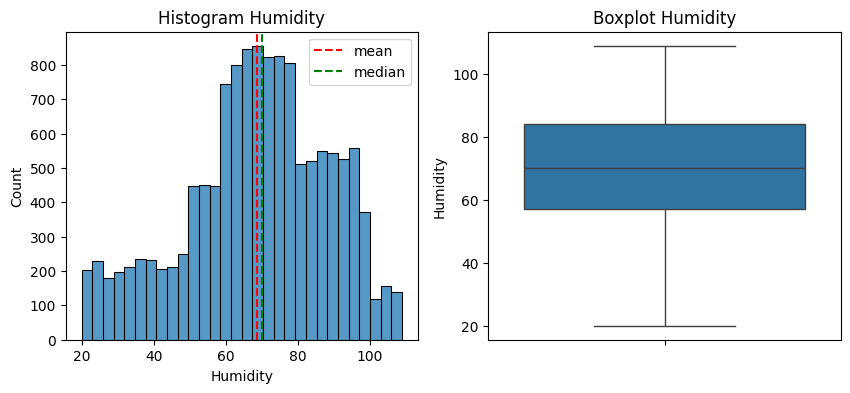

Skewness : -0.40161426558981855
Column |Humidity| left skewed


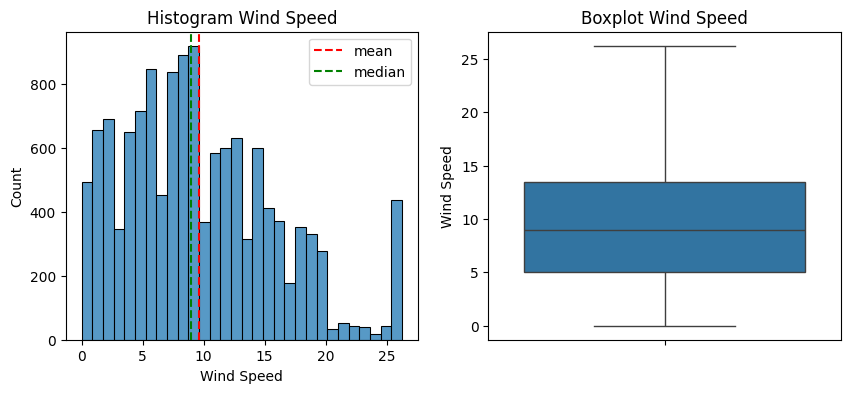

Skewness : 0.6775071072395675
Column |Wind Speed| right skewed


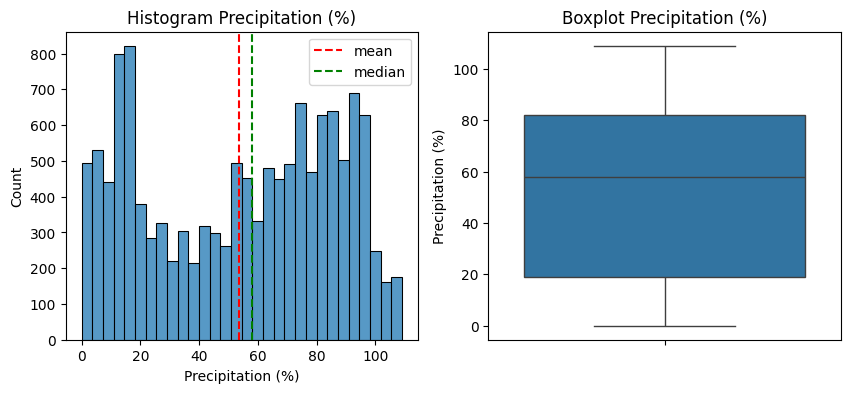

Skewness : -0.15245706717664612
Column |Precipitation (%)| left skewed


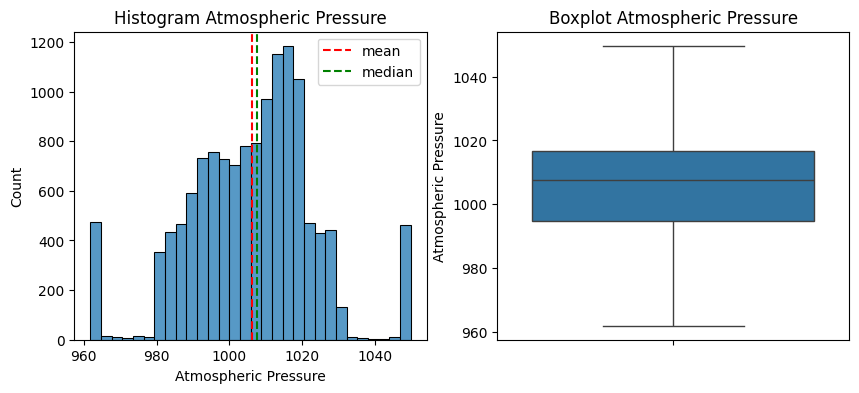

Skewness : -0.11778563343423236
Column |Atmospheric Pressure| left skewed


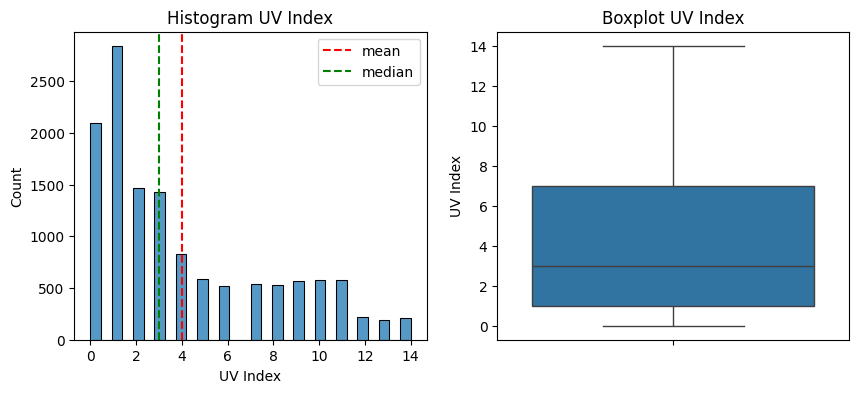

Skewness : 0.9000101823909895
Column |UV Index| right skewed


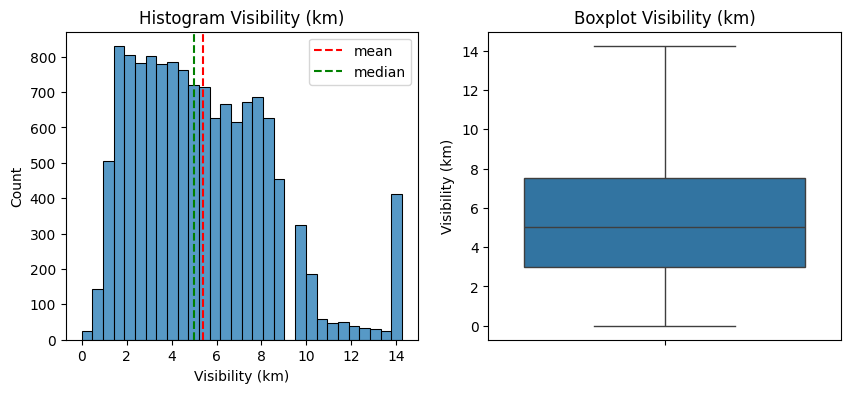

Skewness : 0.724153947034835
Column |Visibility (km)| right skewed


In [14]:
for col in num_int_cols:
    plot_dist(df, col)

## Machine Learning

### **Data Splitting**

In [15]:
X = df.drop(['Weather Type'], axis = 1)
y = df['Weather Type'].map({'Rainy':0, 'Cloudy':1, 'Sunny':2, 'Snowy':3})

print(y.dtypes)

int64


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('Train-set Dimension: ', X_train.shape)
print('Test-set Dimension: ', X_test.shape)

Train-set Dimension:  (10560, 10)
Test-set Dimension:  (2640, 10)


### **Feature Engineering**

In [17]:
print(num_int_cols)
print(object_cols)

['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Atmospheric Pressure', 'UV Index', 'Visibility (km)']
['Cloud Cover', 'Season', 'Location', 'Weather Type']


In [18]:
# Remove 'Weather Type' from the categorical columns
object_cols = [col for col in object_cols if col != 'Weather Type']
object_cols

['Cloud Cover', 'Season', 'Location']

In [19]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore') #ignore unknown categories

# pipeline
pipeline_data = ColumnTransformer([('scaler', scaler, num_int_cols),
                            ('one_encoder', ohe, object_cols)],
                            remainder='passthrough')

In [20]:
X_train = pipeline_data.fit_transform(X_train)
X_test = pipeline_data.transform(X_test)

In [21]:
# Turn back to Dataframe
column_names = num_int_cols + (pipeline_data.named_transformers_['one_encoder'].get_feature_names_out(object_cols).tolist())
column_names

['Temperature',
 'Humidity',
 'Wind Speed',
 'Precipitation (%)',
 'Atmospheric Pressure',
 'UV Index',
 'Visibility (km)',
 'Cloud Cover_clear',
 'Cloud Cover_cloudy',
 'Cloud Cover_overcast',
 'Cloud Cover_partly cloudy',
 'Season_Autumn',
 'Season_Spring',
 'Season_Summer',
 'Season_Winter',
 'Location_coastal',
 'Location_inland',
 'Location_mountain']

In [22]:
X_train_df = pd.DataFrame(X_train, columns = column_names)
X_test_df = pd.DataFrame(X_test, columns = column_names)

display(X_train_df.head(3), X_test_df.head(3))

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,0.746052,-0.129706,-0.582040,1.204747,0.240837,-0.523097,-1.253982,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.247828,1.352488,0.222481,0.109053,0.636403,-1.041944,-0.447459,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.512198,-0.524958,-0.501588,-1.331000,1.126624,1.552291,1.165585,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,0.219880,-1.513087,-0.823396,-1.487528,0.88239,1.292867,1.488194,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.499957,1.253675,0.785646,0.922997,1.13831,1.552291,-0.447459,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.213760,-0.870803,-1.225656,-1.299695,1.11377,1.033444,0.842976,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [23]:
# model Logistic Regression
LR = LogisticRegression(random_state = 42)

# model Support Vector Machine
SVM = SVC(random_state = 42)

# model Random Forest
RF = RandomForestClassifier(random_state = 42)

# model K-Nearest Neighbors
KNN = KNeighborsClassifier()

# model Decision Tree
DT = DecisionTreeClassifier(random_state = 42)

In [24]:
# cross-val method
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# fit model Logistic Regression
scores_logreg = cross_val_score(LR, X_test, y_test, cv=skf, scoring='accuracy')
print('Cross-Validation Scores Logistic Regression:\n', scores_logreg, '\n')

# fit model SVM
scores_svm = cross_val_score(SVM, X_test, y_test, cv=skf, scoring='accuracy')
print('Cross-Validation Scores SVM:\n', scores_svm, '\n')

# fit model Random Forest
scores_ranfor = cross_val_score(RF, X_test, y_test, cv=skf, scoring='accuracy')
print('Cross-Validation Scores Random Forest:\n', scores_ranfor, '\n')

# fit model KNN
scores_knn = cross_val_score(KNN, X_test, y_test, cv=skf, scoring='accuracy')
print('Cross-Validation Scores KNN:\n', scores_knn, '\n')

# fit model Decision Tree
scores_dt = cross_val_score(DT, X_test, y_test, cv=skf, scoring='accuracy')
print('Cross-Validation Scores Decision Tree:\n', scores_dt, '\n')

Cross-Validation Scores Logistic Regression:
 [0.83522727 0.87121212 0.87878788 0.84469697 0.88068182] 

Cross-Validation Scores SVM:
 [0.87689394 0.91098485 0.90530303 0.89015152 0.91287879] 

Cross-Validation Scores Random Forest:
 [0.89015152 0.90719697 0.91666667 0.90151515 0.91477273] 

Cross-Validation Scores KNN:
 [0.86174242 0.8844697  0.88636364 0.8655303  0.87310606] 

Cross-Validation Scores Decision Tree:
 [0.88636364 0.89204545 0.90340909 0.8844697  0.89015152] 



In [25]:
# Logistic Regression
print('Cross-Validation Mean Scores Logistic Regression\t\t:', scores_logreg.mean(),
      '\nCross-Validation Standard Deviation Scores Logistic Regression\t:', scores_logreg.std(), '\n')

# SVM
print('Cross-Validation Mean Scores SVM\t\t\t\t:', scores_svm.mean(),
      '\nCross-Validation Standard Deviation Scores SVM\t\t\t:', scores_svm.std(), '\n')

# Random Forest
print('Cross-Validation Mean Scores Random Forest\t\t\t:', scores_ranfor.mean(),
      '\nCross-Validation Standard Deviation Scores Random Forest\t:', scores_ranfor.std(), '\n')

# KNN
print('Cross-Validation Mean Scores KNN\t\t\t\t:', scores_knn.mean(),
      '\nCross-Validation Standard Deviation Scores KNN\t\t\t:', scores_knn.std(), '\n')

# Decision Tree
print('Cross-Validation Mean Scores Decision Tree\t\t\t:', scores_dt.mean(),
      '\nCross-Validation Standard Deviation Scores Decision Tree\t:', scores_dt.std(), '\n')

Cross-Validation Mean Scores Logistic Regression		: 0.8621212121212121 
Cross-Validation Standard Deviation Scores Logistic Regression	: 0.018610785600815537 

Cross-Validation Mean Scores SVM				: 0.8992424242424242 
Cross-Validation Standard Deviation Scores SVM			: 0.013730734060902902 

Cross-Validation Mean Scores Random Forest			: 0.906060606060606 
Cross-Validation Standard Deviation Scores Random Forest	: 0.009627473505408211 

Cross-Validation Mean Scores KNN				: 0.8742424242424243 
Cross-Validation Standard Deviation Scores KNN			: 0.009848484848484877 

Cross-Validation Mean Scores Decision Tree			: 0.8912878787878789 
Cross-Validation Standard Deviation Scores Decision Tree	: 0.006626081698687846 



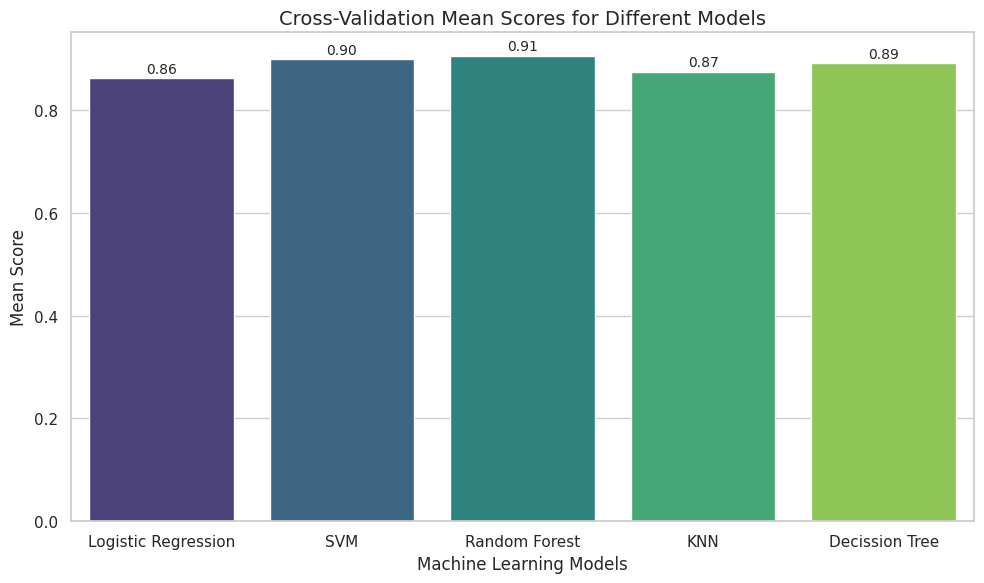

In [26]:
model_names = ['Logistic Regression', 'SVM', 'Random Forest', 'KNN', 'Decission Tree']
mean_scores = [
    scores_logreg.mean(),
    scores_svm.mean(),
    scores_ranfor.mean(),
    scores_knn.mean(),
    scores_dt.mean()
]

data = pd.DataFrame({'Model': model_names, 'Mean Score': mean_scores})

# Plot the bar chart
sns.set(style = "whitegrid")
plt.figure(figsize = (10, 6))
barplot = sns.barplot(x = 'Model', y = 'Mean Score', data = data, palette = 'viridis')

# Add annotations
for i in range(len(mean_scores)):
    barplot.text(i, mean_scores[i] + 0.005, f"{mean_scores[i]:.2f}", ha = 'center', va = 'bottom', fontsize = 10)

plt.title('Cross-Validation Mean Scores for Different Models', fontsize = 14)
plt.xticks(rotation = 0)
plt.xlabel('Machine Learning Models', fontsize = 12)
plt.ylabel('Mean Score', fontsize = 12)
plt.tight_layout()

# Show the plot
plt.show()


In [27]:
models = {
    "Random Forest": RandomForestClassifier(random_state = 42),
    "SVM": SVC(random_state = 42),
    "Decision Tree": DecisionTreeClassifier(random_state = 42)
}

In [28]:
for model_name, model in models.items():
    print(f"# Model: {model_name}\n")

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("Classification Report Train-set:\n", classification_report(y_train, y_pred_train))
    print("Classification Report Test-set:\n", classification_report(y_test, y_pred_test))
    print("=" * 80)

# Model: Random Forest

Classification Report Train-set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2653
           1       1.00      1.00      1.00      2649
           2       1.00      1.00      1.00      2659
           3       1.00      1.00      1.00      2599

    accuracy                           1.00     10560
   macro avg       1.00      1.00      1.00     10560
weighted avg       1.00      1.00      1.00     10560

Classification Report Test-set:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90       647
           1       0.88      0.89      0.89       651
           2       0.94      0.90      0.92       641
           3       0.93      0.94      0.94       701

    accuracy                           0.91      2640
   macro avg       0.91      0.91      0.91      2640
weighted avg       0.91      0.91      0.91      2640

# Model: SVM

Classification Report Tra

In [29]:
RF = RandomForestClassifier(random_state = 42)

RF_paramgrid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5],
    'max_features': ['sqrt', 'log2', 'auto']
}

RF_grid = GridSearchCV(RF, RF_paramgrid, cv=5, scoring='accuracy')
RF_grid.fit(X_train, y_train)
print("Best parameters for Random Forest:\n", RF_grid.best_params_)
print('Best Score Random Forest:', RF_grid.best_score_)

Best parameters for Random Forest:
 {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}
Best Score Random Forest: 0.9073863636363637


In [42]:
SVM = SVC(random_state = 42)

SVM_paramgrid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

SVM_grid = GridSearchCV(SVM, SVM_paramgrid, cv=5, scoring='accuracy')
SVM_grid.fit(X_train, y_train)
print("Best parameters for SVM:\n", SVM_grid.best_params_)
print('Best Score SVM:', SVM_grid.best_score_)

Best parameters for SVM:
 {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score SVM: 0.9111742424242424


In [31]:
DT = DecisionTreeClassifier(random_state = 42)

DT_paramgrid = {
    'max_depth': [1, 3, 5, 7, 9],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2', 'auto']
}

DT_grid = GridSearchCV(DT, DT_paramgrid, cv=5, scoring='accuracy')
DT_grid.fit(X_train, y_train)
print("Best parameters for Decision Tree:\n", DT_grid.best_params_)
print('Best Score Decision Tree:', DT_grid.best_score_)

Best parameters for Decision Tree:
 {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt'}
Best Score Decision Tree: 0.9030303030303031


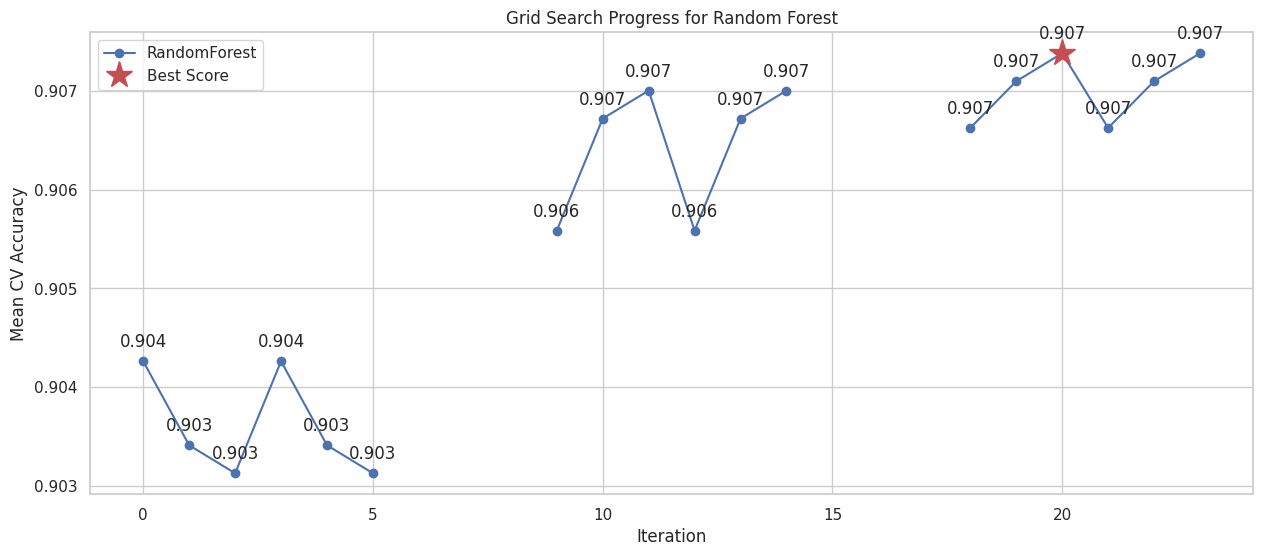

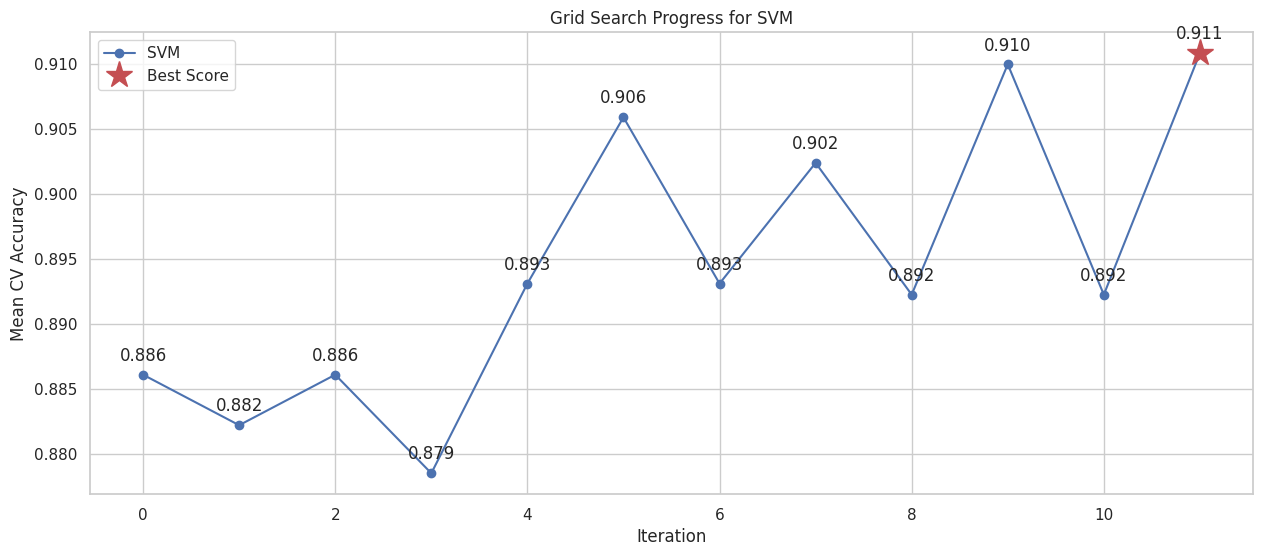

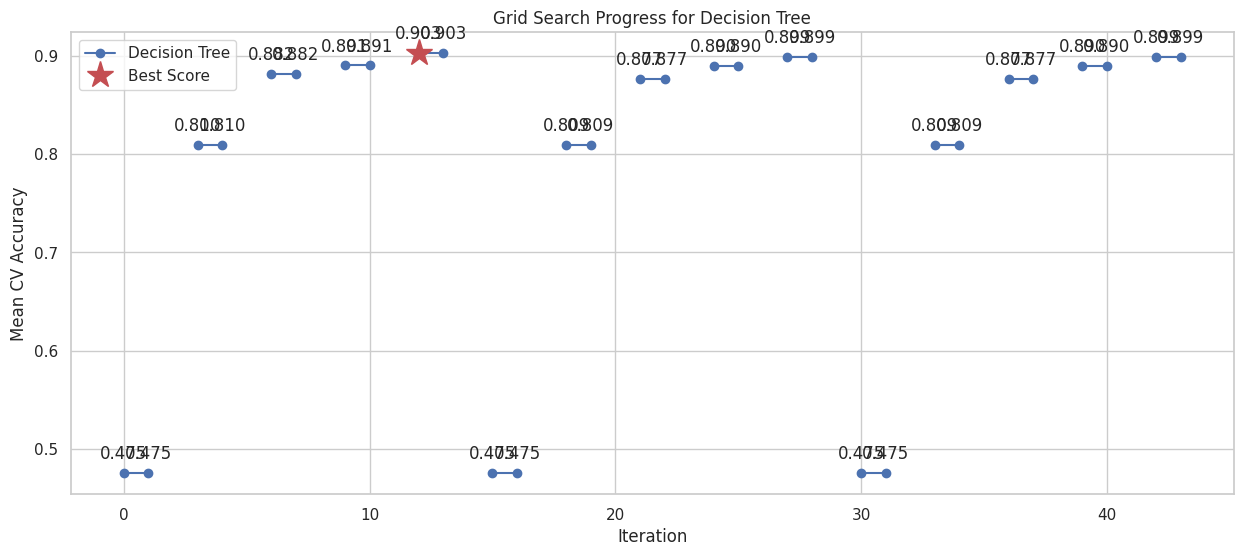

In [32]:
models = [
    ('Random Forest', RF_grid, 'RandomForest'),
    ('SVM', SVM_grid, 'SVM'),
    ('Decision Tree', DT_grid, 'Decision Tree')
]

for model_name, grid_search, label in models:
    results = pd.DataFrame(grid_search.cv_results_)

    plt.figure(figsize=(15, 6))
    plt.plot(results['mean_test_score'], 'o-', label=label)
    plt.xlabel('Iteration')
    plt.ylabel('Mean CV Accuracy')
    plt.title(f'Grid Search Progress for {model_name}')

    for i, score in enumerate(results['mean_test_score']):
        plt.annotate(f'{score:.3f}', (i, score), textcoords="offset points", xytext=(0,10), ha='center')

    best_index = results['mean_test_score'].idxmax()
    plt.plot(best_index, results.loc[best_index, 'mean_test_score'], 'r*', markersize=20, label='Best Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [33]:
best_params_RF = RF_grid.best_params_
best_model_RF = RandomForestClassifier(random_state = 42)
best_model_RF.set_params(**best_params_RF)

best_model_RF.fit(X_train, y_train)

y_pred_train_RF = best_model_RF.predict(X_train)
y_pred_test_RF = best_model_RF.predict(X_test)

print('Classification Report Train-set:\n', classification_report(y_train, y_pred_train_RF))
print(f"Accuracy Score Train-set: {accuracy_score(y_train, y_pred_train_RF):.4f}\n")

print('Classification Report Test-set:\n', classification_report(y_test, y_pred_test_RF))
print(f"Accuracy Score Test-set: {accuracy_score(y_test, y_pred_test_RF):.4f}")

Classification Report Train-set:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      2653
           1       0.87      0.90      0.88      2649
           2       0.94      0.92      0.93      2659
           3       0.98      0.91      0.95      2599

    accuracy                           0.92     10560
   macro avg       0.92      0.92      0.92     10560
weighted avg       0.92      0.92      0.92     10560

Accuracy Score Train-set: 0.9168

Classification Report Test-set:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90       647
           1       0.85      0.89      0.87       651
           2       0.94      0.89      0.91       641
           3       0.98      0.93      0.96       701

    accuracy                           0.91      2640
   macro avg       0.91      0.91      0.91      2640
weighted avg       0.91      0.91      0.91      2640

Accuracy Score Test-set: 0.90

In [43]:
best_params_SVM = SVM_grid.best_params_
best_model_SVM = SVC(random_state = 42)
best_model_SVM.set_params(**best_params_SVM)

best_model_SVM.fit(X_train, y_train)

y_pred_train_SVM = best_model_SVM.predict(X_train)
y_pred_test_SVM = best_model_SVM.predict(X_test)

print('Classification Report Train-set:\n', classification_report(y_train, y_pred_train_SVM))
print(f"Accuracy Score Train-set: {accuracy_score(y_train, y_pred_train_SVM):.4f}\n")

print('Classification Report Test-set:\n', classification_report(y_test, y_pred_test_SVM))
print(f"Accuracy Score Test-set: {accuracy_score(y_test, y_pred_test_SVM):.4f}")

Classification Report Train-set:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95      2653
           1       0.96      0.94      0.95      2649
           2       0.97      0.96      0.97      2659
           3       0.97      0.97      0.97      2599

    accuracy                           0.96     10560
   macro avg       0.96      0.96      0.96     10560
weighted avg       0.96      0.96      0.96     10560

Accuracy Score Train-set: 0.9612

Classification Report Test-set:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88       647
           1       0.87      0.88      0.87       651
           2       0.94      0.91      0.92       641
           3       0.94      0.94      0.94       701

    accuracy                           0.91      2640
   macro avg       0.91      0.91      0.91      2640
weighted avg       0.91      0.91      0.91      2640

Accuracy Score Test-set: 0.90

In [35]:
best_params_DT = DT_grid.best_params_
best_model_DT = DecisionTreeClassifier(random_state=42)
best_model_DT.set_params(**best_params_DT)

best_model_DT.fit(X_train, y_train)

y_pred_train_DT = best_model_DT.predict(X_train)
y_pred_test_DT = best_model_DT.predict(X_test)

print('Classification Report Train-set:\n', classification_report(y_train, y_pred_train_DT))
print(f"Accuracy Score Train-set: {accuracy_score(y_train, y_pred_train_DT):.4f}\n")

print('Classification Report Test-set:\n', classification_report(y_test, y_pred_test_DT))
print(f"Accuracy Score Test-set: {accuracy_score(y_test, y_pred_test_DT):.4f}")

Classification Report Train-set:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      2653
           1       0.93      0.90      0.91      2649
           2       0.94      0.94      0.94      2659
           3       0.94      0.94      0.94      2599

    accuracy                           0.92     10560
   macro avg       0.93      0.92      0.92     10560
weighted avg       0.93      0.92      0.92     10560

Accuracy Score Train-set: 0.9248

Classification Report Test-set:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       647
           1       0.90      0.86      0.88       651
           2       0.92      0.90      0.91       641
           3       0.91      0.93      0.92       701

    accuracy                           0.89      2640
   macro avg       0.89      0.89      0.89      2640
weighted avg       0.89      0.89      0.89      2640

Accuracy Score Test-set: 0.89

In [44]:
results = {
    "Model": ["Random Forest", "SVM", "Decision Tree"],
    "Train Accuracy": [
        accuracy_score(y_train, y_pred_train_RF),
        accuracy_score(y_train, y_pred_train_SVM),
        accuracy_score(y_train, y_pred_train_DT)
    ],
    "Test Accuracy": [
        accuracy_score(y_test, y_pred_test_RF),
        accuracy_score(y_test, y_pred_test_SVM),
        accuracy_score(y_test, y_pred_test_DT)
    ]
}

results = pd.DataFrame(results)
results_df = results.set_index("Model")
results_df

,Train Accuracy,Test Accuracy
Model,,
Random Forest,0.916761,0.907955
SVM,0.961174,0.906439
Decision Tree,0.924811,0.893939


In [37]:
results_long = results_df.reset_index().melt(id_vars="Model", var_name="Dataset", value_name="Accuracy")
results_long

,Model,Dataset,Accuracy
0,Random Forest,Train Accuracy,0.916761
1,SVM,Train Accuracy,0.930208
2,Decision Tree,Train Accuracy,0.924811
3,Random Forest,Test Accuracy,0.907955
4,SVM,Test Accuracy,0.907955
5,Decision Tree,Test Accuracy,0.893939


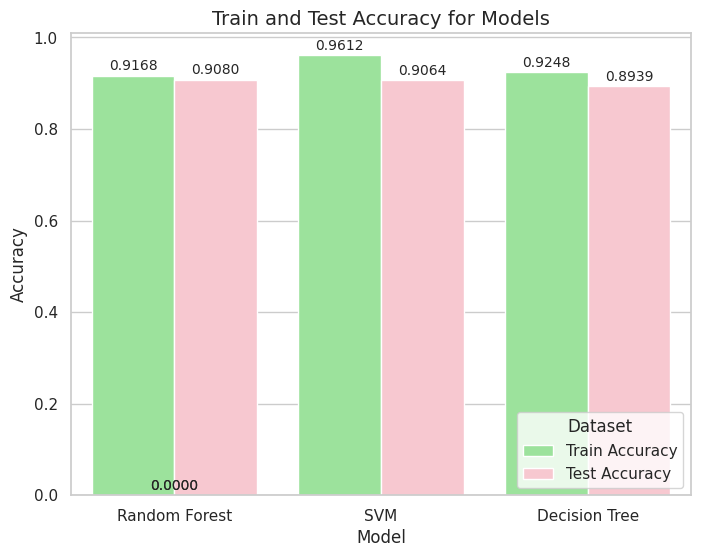

In [55]:
results_long = results_df.reset_index().melt(id_vars = "Model", var_name = "Dataset", value_name = "Accuracy")

palette = {"Train Accuracy": "lightgreen", "Test Accuracy": "pink"}

plt.figure(figsize = (8, 6))
barplot = sns.barplot(data = results_long, x = "Model", y = "Accuracy", hue = "Dataset", palette = palette)

for p in barplot.patches:
    height = p.get_height()
    barplot.text(x = p.get_x() + p.get_width() / 2,
                 y = height + 0.005,
                 s = f'{height:.4f}',
                 ha = 'center',
                 va = 'bottom',
                 fontsize = 10)

plt.xlabel("Model", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.title("Train and Test Accuracy for Models", fontsize = 14)
plt.legend(title = "Dataset", loc = "lower right")
plt.show()

### **Use Random Forest**

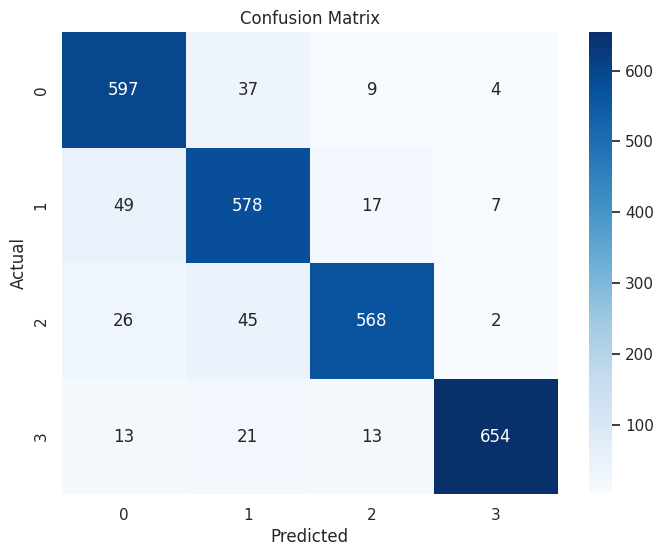

In [40]:
cm = confusion_matrix(y_test, y_pred_test_RF)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

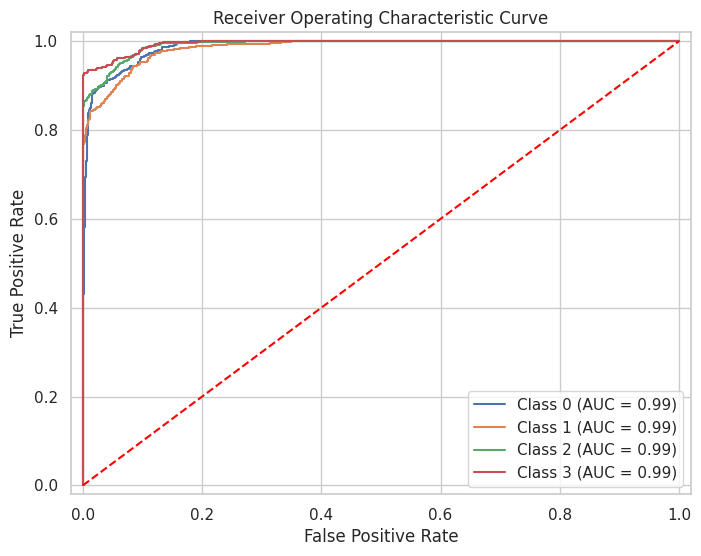

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_binarized.shape[1]

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    # Get the predicted probabilities for the current class
    preds = best_model_RF.predict_proba(X_test)[:, i]

    # Calculate False Positive Rate (FPR), True Positive Rate (TPR), and threshold values for each class
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], preds)

    # Calculate the AUC (Area Under the Curve) for each class
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve for the current class
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.ylim([-0.02, 1.02])
plt.xlim([-0.02, 1.02])
plt.show()
